<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Linear regression: Training and Validation Data</h1> 


<h2>Objective</h2><ul><li> How to use learning rate hyperparameter to improve your model result.  .</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will learn to select the best learning rate by using validation data.</p>
 
<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3">
        1. <a href="#Make-Some-Data">Make Some Data</a><br>
        2. <a href="#Create-a-Linear-Regression-Object-Data-Loader-and-Criterion-Function">Create a Linear Regression Object Data Loader and Criterion Function</a><br>
        3. <a href="#Different-learning-rates-and-Data-Structures-to-Store-results-for-Different-Hyperparameters">Different learning rates and Data Structures to Store results for Different Hyperparameters</a><br>
        4. <a href="#Train-different-modules-for-different-Hyperparameters">Train different modules for different Hyperparameters</a><br>
        5. <a href="#View-Results">View Results</a><br>
    
<p>Estimated Time Needed: <strong>30 min</strong></p>
</font>
</div>


<h2>Preparation</h2>


We'll need the following libraries and set the random seed.


In [1]:
%%time
%pip install numpy matplotlib
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 170.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 159.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 151.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 146.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 MB 48.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 104.2 MB/s eta 0:00:00
Note:

In [2]:
# Import libraries we need for this lab, and set the random seed

from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim

<!--Empty Space for separating topics-->


<!-- <h2 id="Makeup_Data">Make Some Data</h2> -->
## Make Some Data


First, we'll create some artificial data in a dataset class. The class will include the option to produce training data or validation data. The training data will include outliers.


In [3]:
# Create Data class

from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    
    # Constructor
    def __init__(self, train = True):
            self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
            self.f = -3 * self.x + 1
            self.y = self.f + 0.1 * torch.randn(self.x.size())
            self.len = self.x.shape[0]
            
            #outliers 
            if train == True:
                self.y[0] = 0
                self.y[50:55] = 20
            else:
                pass
      
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

Create two objects: one that contains training data and a second that contains validation data. Assume that the training data has the outliers. 


In [4]:
# Create training dataset and validation dataset

train_data = Data()
val_data = Data(train = False)

Overlay the training points in red over the function that generated the data. Notice the outliers at x=-3 and around x=2:


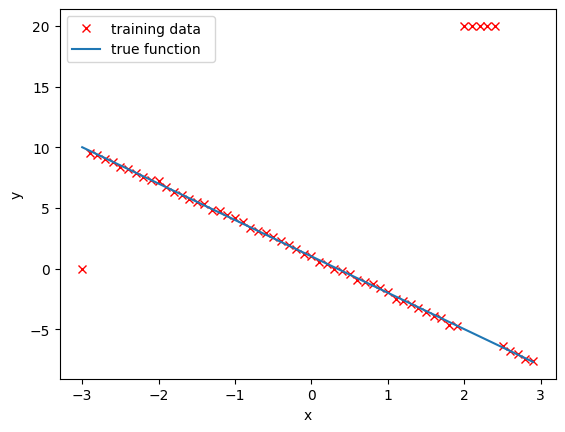

In [5]:
# Plot out training points

plt.plot(train_data.x.numpy(), train_data.y.numpy(), 'xr',label="training data ")
plt.plot(train_data.x.numpy(), train_data.f.numpy(),label="true function  ")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<!--Empty Space for separating topics-->


<!-- <h2 id="LR_Loader_Cost">Create a Linear Regression Object,  Data Loader, and Criterion Function</h2> -->
## Create a Linear Regression Object Data Loader and Criterion Function


In [6]:
# Create Linear Regression Class

from torch import nn

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # Prediction function
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

Create the criterion function and a <code>DataLoader</code> object: 


In [7]:
# Create MSELoss function and DataLoader

criterion = nn.MSELoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)

<!--Empty Space for separating topics-->


<!-- <h2 id="LR_Hyper">Different learning rates and Data Structures to Store results for different Hyperparameters</h2> -->
## Different learning rates and Data Structures to Store results for Different Hyperparameters


Create a list with different learning rates and a tensor (can be a list) for the training and validating cost/total loss. Include the list MODELS, which stores the training model for every value of the learning rate. 


In [8]:
# Create Learning Rate list, the error lists and the MODELS list

learning_rates=[0.0001, 0.001, 0.01, 0.1]

train_error=torch.zeros(len(learning_rates))
validation_error=torch.zeros(len(learning_rates))

MODELS=[]

<!--Empty Space for separating topics-->


<!-- <h2 id="Model">Train different models  for different Hyperparameters</h2> -->
## Train different modules for different Hyperparameters


Try different values of learning rates, perform stochastic gradient descent, and save the results on the training data and validation data. Finally, save each model in a list.


In [9]:
# Define the train model function and train the model

def train_model_with_lr (iter, lr_list):
    
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        model = linear_regression(1, 1)
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):
            for x, y in trainloader:
                yhat = model(x)
                loss = criterion(yhat, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # train data
        Yhat = model(train_data.x)
        train_loss = criterion(Yhat, train_data.y)
        train_error[i] = train_loss.item()
    
        # validation data
        Yhat = model(val_data.x)
        val_loss = criterion(Yhat, val_data.y)
        validation_error[i] = val_loss.item()
        MODELS.append(model)

train_model_with_lr(10, learning_rates)

<!--Empty Space for separating topics-->


<!-- <h2 id="Result">View the Results</h2>
 -->
## View Results


Plot the training loss and validation loss for each learning rate:  


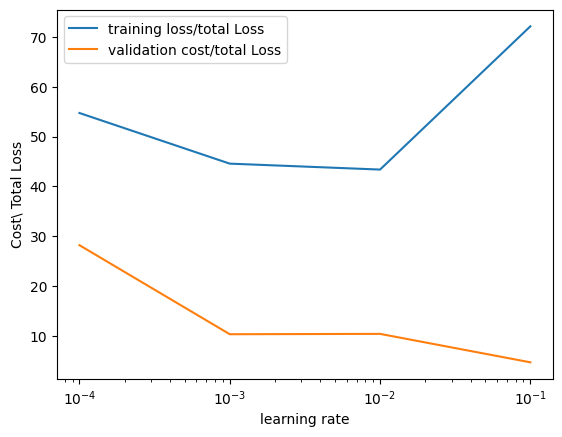

In [10]:
# Plot the training loss and validation loss

plt.semilogx(np.array(learning_rates), train_error.numpy(), label = 'training loss/total Loss')
plt.semilogx(np.array(learning_rates), validation_error.numpy(), label = 'validation cost/total Loss')
plt.ylabel('Cost\ Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

Produce a prediction by using the validation data for each model:  


0 [[0.4003082 ]
 [0.40445504]
 [0.40860188]]
1 [[5.4386883]
 [5.319148 ]
 [5.199608 ]]
2 [[6.6154747]
 [6.4808683]
 [6.3462615]]
3 [[14.122414]
 [13.699734]
 [13.277053]]


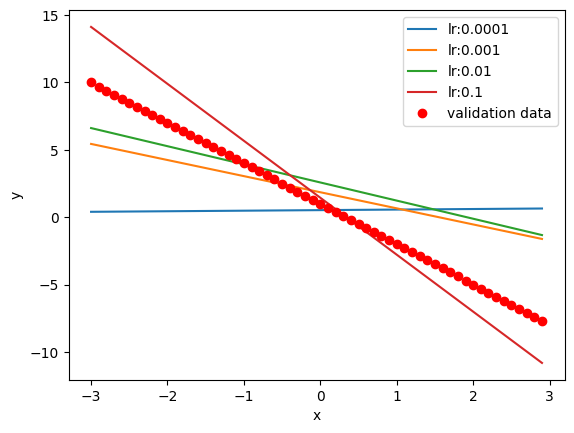

In [11]:
# Plot the predictions

i = 0
for model, learning_rate in zip(MODELS, learning_rates):
    yhat = model(val_data.x)
    plt.plot(val_data.x.numpy(), yhat.detach().numpy(), label = 'lr:' + str(learning_rate))
    print(i, yhat.detach().numpy()[0:3])
    i+=1
plt.plot(val_data.x.numpy(), val_data.f.numpy(), 'or', label = 'validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<!--Empty Space for separating topics-->


<h3>Practice</h3>


The object <code>good_model</code> is the best performing model. Use the train loader to get the data samples x and y. Produce an estimate for <code>yhat</code> and print it out for every sample in a for a loop. Compare it to the actual prediction <code>y</code>.


In [12]:
good_model = MODELS[np.argmin(validation_error)]

#Type your code here:
for x, y in trainloader:
    print("yhat= ", model(x),"y", y)

yhat=  tensor([[14.1224]], grad_fn=<AddmmBackward0>) y tensor([[0.]])
yhat=  tensor([[13.6997]], grad_fn=<AddmmBackward0>) y tensor([[9.5619]])
yhat=  tensor([[13.2771]], grad_fn=<AddmmBackward0>) y tensor([[9.3239]])
yhat=  tensor([[12.8544]], grad_fn=<AddmmBackward0>) y tensor([[9.0275]])
yhat=  tensor([[12.4317]], grad_fn=<AddmmBackward0>) y tensor([[8.7660]])
yhat=  tensor([[12.0090]], grad_fn=<AddmmBackward0>) y tensor([[8.3441]])
yhat=  tensor([[11.5863]], grad_fn=<AddmmBackward0>) y tensor([[8.2359]])
yhat=  tensor([[11.1637]], grad_fn=<AddmmBackward0>) y tensor([[7.8746]])
yhat=  tensor([[10.7410]], grad_fn=<AddmmBackward0>) y tensor([[7.5237]])
yhat=  tensor([[10.3183]], grad_fn=<AddmmBackward0>) y tensor([[7.2999]])
yhat=  tensor([[9.8956]], grad_fn=<AddmmBackward0>) y tensor([[7.2229]])
yhat=  tensor([[9.4729]], grad_fn=<AddmmBackward0>) y tensor([[6.7617]])
yhat=  tensor([[9.0503]], grad_fn=<AddmmBackward0>) y tensor([[6.3272]])
yhat=  tensor([[8.6276]], grad_fn=<AddmmBackw

Double-click <b>here</b> for the solution.

<!-- 
for x, y in trainloader:
    print("yhat= ", model(x),"y", y)
-->




<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/">Mavis Zhou</a>


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |

-->


<hr>





## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
